# d13C

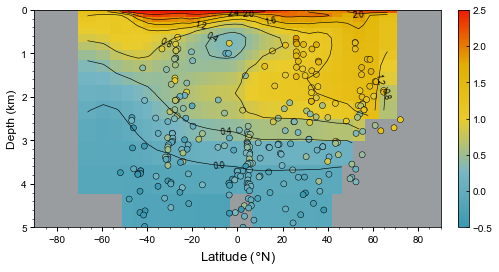

In [128]:
from geniepy.core import GenieModel
from geniepy.plot import scatter_on_GENIE, genie_cmap
from geniepy.grid import detect_ocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

basin = 'Atlantic'
odv = genie_cmap('Zissou1', reverse=False)
# plot model data
dic_13c = GenieModel("../model/LGM_8P8Z").select_var('ocn_DIC_13C')
dic_13c.mask_basin('GIteiiaa', basin=basin, basin_lvl="ALL").mean_along("lon").cross_section(ax=ax, cmap=odv, vmin=-0.5, vmax=2.5)

# plot observed data
data = pd.read_csv("../data/LGM_productivity/LGM_d13c_CLEAN.txt", sep='\t', header=None)
data.columns = ['Longitude', 'Latitude', 'Depth', 'd13C', 'core']
data = data.apply(pd.to_numeric, args=('coerce',))
data['Depth'] = data['Depth']/1000
data['basin'] = data.apply(lambda x: detect_ocean(x.Longitude, x.Latitude), axis=1)
# subset data
data = data[data['basin'].str.contains(r'Atlantic')]

ax.scatter(x=data.Latitude, y=data.Depth, c=data.d13C, cmap=odv, vmin=-.5, vmax=2.5, edgecolor='black',
linewidth=.5)

In [52]:
def model_output(df):
    lat = df.Latitude
    lon = df.Longitude
    zt = df.Depth

    return GenieModel("../model/LGM_2P2Z").diff('../model/Hol_2P2Z', 'ocn_DIC_13C').search_grid(lat=lat, lon=lon, zt=zt).values

data = pd.read_csv("../data/LGM_productivity/LGM_d13c_CLEAN.txt", sep='\t', header=None)
data.columns = ['Longitude', 'Latitude', 'Depth', 'd13C', 'core']
data = data.apply(pd.to_numeric, args=('coerce',))

x = data.apply(model_output, axis=1) - data.d13C
x.abs().sum()

144.59754693804962

# Oxygen (mostly qualitative)

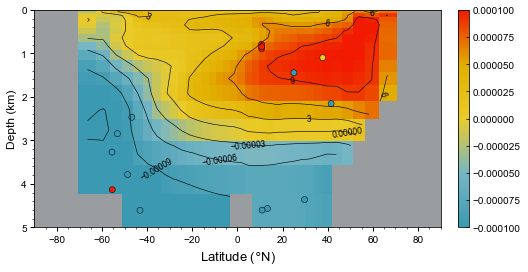

In [135]:
fig, ax = plt.subplots(figsize=(8, 4))

basin = 'Atlantic'
odv = genie_cmap('Zissou1', reverse=False)
# plot model data
o2 = GenieModel("../model/LGM_biogem").diff('../model/Hol_biogem', 'ocn_O2')
o2.mask_basin('GIteiiaa', basin=basin, basin_lvl="ALL").mean_along("lon").cross_section(ax=ax, cmap=odv, vmin=-1e-4, vmax=1e-4)

# plot observed data
#data = pd.read_csv('../data/LGM_productivity/Galbraith&Jaccard_2015.csv')
#data['delta'] = np.sign(data['LGM-Hol'])

# data with only 15N are removed
#data = pd.read_csv('../data/LGM_productivity/Jaccard&Galbraith_2012.csv')
#data['delta'] = data['Hol-LGM'] * -1

data = pd.read_csv('../data/LGM_productivity/Kobayashi_etal_2021.csv')
data['basin'] = data.apply(lambda x: detect_ocean(x.Longitude, x.Latitude), axis=1)

data['Depth'] = data['Depth']/1000
#data['Delta_O2'] = data['Delta_O2']/1E6 #from umol/kg to mol/kg

data = data[data['Type'] == 'Qualitative']
data = data[data['basin'].str.contains(r'Atlantic')]

ax.scatter(x=data.Latitude, y=data.Depth, c=data.Delta_O2, cmap=odv, edgecolor='black', linewidth=.5, vmin=-1e-4, vmax=1e-4)

# Export production

-4.348482


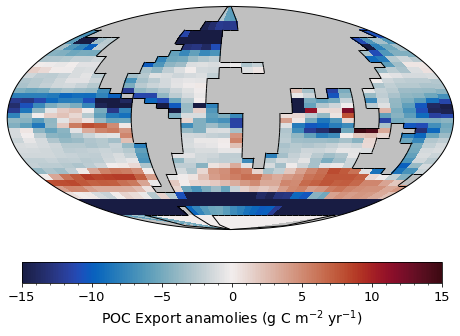

In [5]:
from cgeniepy.core import GenieModel
from cgeniepy.plot import plot_genie, scatter_on_genie
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import cmocean

def dEP(lgm_path, hol_path, gem='ecogem'):

    hol = GenieModel(hol_path)
    lgm =  GenieModel(lgm_path)

    ## ecogem
    if gem=='ecogem':
        diff = lgm.select_var("eco2D_Uptake_Fluxes_C") - hol.select_var("eco2D_Uptake_Fluxes_C")
        # mmol C m-3 d-1 to g C m-2 yr-1
        diff.array = diff.array * 12 / 1000 * 80.8 * 365
        diff.unit = r"Primary Production anamolies (g C m$^{-2}$ yr$^{-1}$)"
    elif gem == 'biogem':
        diff = lgm.select_var("bio_export_POC") - hol.select_var("bio_export_POC")        
        diff.array = diff.array * 12
        diff.unit = r"POC Export anamolies (g C m$^{-2}$ yr$^{-1}$)"
    return diff
    
diff = dEP('../model/LGM_diat.Aaron23', "../model/Hol_diat.Aaron23/", 'biogem')
print(diff.nanmean())

vmax=15
vmin=-15

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.Mollweide()))
p1 = plot_genie(ax, data=diff.array, vmin=vmin, vmax=vmax, cmap = "cmo.balance")

#obs = pd.read_csv("../data/LGM_productivity/combined_data.csv")
#obs['Productivity_anomlies'] = obs['Productivity_anomlies'] * vmax/2
#p2 = scatter_on_genie(ax, obs, "Productivity_anomlies", vmin=vmin, vmax=vmax, cmap = "cmo.balance")

cax = fig.add_axes([0.15, 0.12, 0.73, 0.05]) #xmin, ymin, dx, dy
cbar = fig.colorbar(p1, cax = cax, orientation = 'horizontal', pad=0.04)
cbar.ax.tick_params(labelsize=13)
cbar.minorticks_on()
cbar.set_label(diff.unit, size=14)
#plt.savefig("../output/LGM_NPP_anomly.jpg", dpi=300)

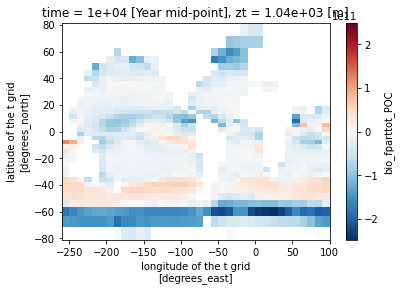

In [5]:
from cgeniepy.core import GenieModel as GM
import matplotlib.pyplot as plt
x = GM("../model/LGM_diat.Aaron23/").select_var("bio_fparttot_POC").search_grid(zt=1000)
y = GM("../model/Hol_diat.Aaron23/").select_var("bio_fparttot_POC").search_grid(zt=1000)

diff = x-y
diff.plot()
plt.savefig("test.jpg")

# absolute NPP (LGM)

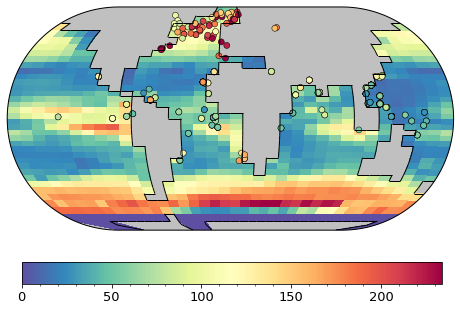

In [2]:
from geniepy.core import GenieModel
from geniepy.plot import plot_GENIE, scatter_on_GENIE
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import cmocean

# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"Water_depth": "Depth (m)", "LGM": "NPP"}, axis=1)
radi = radi.drop(columns=['Modern', 'anomalies(gC/m2/yr)'])

# mgC m-2 d-1 to gC m-2 yr-1
ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_raw.csv")
ha = ha[ha['Time period'] == 'LGM']
ha = ha[ha['Latitude (N)'].abs() <= 30]
ha = ha.rename({"Latitude (N)": "Latitude", "Longitude (E)": "Longitude"}, axis=1)
ha['NPP'] = ha['NPP(mg C/m2/day)'] / 1000 * 365

df = pd.concat([ha, radi])

model = GenieModel("../model/LGM_1P1Z").select_var("eco2D_Uptake_Fluxes_C")
model.array = model.array * 12 / 1000 * 80.8 * 365

vmax = model.max().values
vmin = 0

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.EckertIV()))
p = plot_GENIE(ax, data=model.array, vmin=vmin, vmax=vmax)
p = scatter_on_GENIE(ax, df, "NPP", vmin=vmin, vmax=vmax)
cax = fig.add_axes([0.15, 0.12, 0.73, 0.05]) #xmin, ymin, dx, dy
cbar = fig.colorbar(p, cax = cax, orientation = 'horizontal', pad=0.04)
cbar.ax.tick_params(labelsize=13)
cbar.minorticks_on()

# NPP anomaly (LGM - HOL)

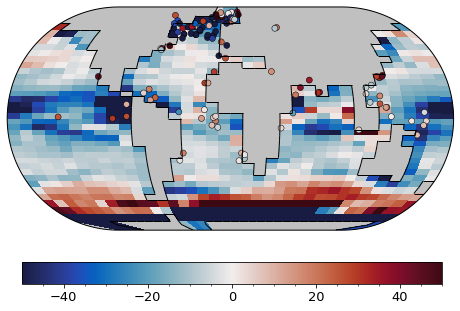

In [3]:
import cmocean
# mgC m-2 d-1
ha = pd.read_csv("../data/LGM_productivity/Hernandez-Almeida_etal_2019_anomaly.csv")
ha = ha.rename({"anomaly(mg_C/m2/day)": "anomaly"}, axis=1)
ha['anomaly'] = ha['anomaly'] / 1000 * 365
ha = ha[['Longitude', "Latitude", "anomaly"]]

# gC m-2 yr-1
radi = pd.read_csv("../data/LGM_productivity/Radi_etal_2008.csv")
radi = radi.rename({"anomalies(gC/m2/yr)": "anomaly"}, axis=1)
radi = radi[['Longitude', "Latitude", "anomaly"]]

# merge datasets
df = pd.concat([ha, radi])

# get model anomaly
diff = GenieModel("../model/LGM_1P1Z").diff("../model/Hol_1P1Z", "eco2D_Uptake_Fluxes_C")

# convert unit
# mmol C m-3 d-1 to g C m-2 yr-1
diff.array = diff.array * 12 / 1000 * 80.8 * 365
diff.unit = r"Primary Production anamolies (g C m$^{-2}$ yr$^{-1}$)"

vmax = 50
vmin = vmax * -1

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.EckertIV()))
p = plot_GENIE(ax, data=diff.array, vmin=vmin, vmax=vmax, cmap="cmo.balance")
p = scatter_on_GENIE(ax, df, "anomaly", vmin=vmin, vmax=vmax, cmap="cmo.balance")

cax = fig.add_axes([0.15, 0.12, 0.73, 0.05]) #xmin, ymin, dx, dy
cbar = fig.colorbar(p, cax = cax, orientation = 'horizontal', pad=0.04)
cbar.ax.tick_params(labelsize=13)
cbar.minorticks_on()

# d15N (bulk)

<AxesSubplot:>

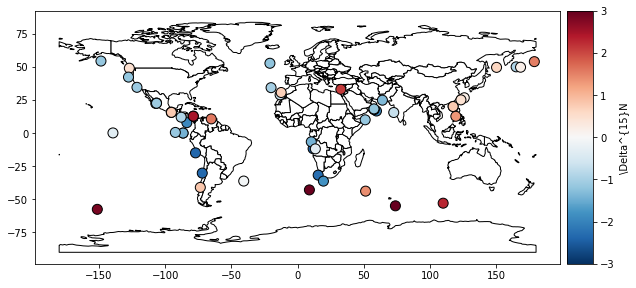

In [27]:
import geopandas
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

df = pd.read_csv("../data/LGM_productivity/Schmittner_etal_2016.csv")
gdf = geopandas.GeoDataFrame(
    df, 
    geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude'])
    )

fig, ax = plt.subplots(figsize=(10,8))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax,color='white', edgecolor='black')
gdf.plot(ax=ax, column=gdf['Delta'], cmap="RdBu_r", legend=True, cax=cax, 
                legend_kwds={'label': r"\Delta^{15}N",
                        'orientation': "vertical"},
                        vmin=-3, vmax=3, markersize=100, edgecolor="k")

# 14C age

# dSST (LGM - HOL)